<h3>Interest Rates Project</h3>

Team: 

<ul>
    <li>Mikhail Mironov</li>
    <li>Alexander Ilyuk</li>
</ul>

In [1]:
from tqdm import tqdm
from typing import *


import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import seaborn as sns


warnings.filterwarnings("ignore")

<h3>Data downloading</h3>

In [ ]:
dates = pd.date_range("2012-01-01","2024-04-01",freq='d')
dates = dates.strftime('%Y-%m-%d')
prms_curve = pd.DataFrame()

for date in tqdm(dates): 
    url = f"https://iss.moex.com/iss/engines/stock/zcyc.html?iss.only=params&date={date}"
    params = pd.read_html(url, encoding="utf-8")[0]
    params.columns = [i.split(' ')[0] for i in params.columns]
    prms_curve = pd.concat([prms_curve,params], axis=0)

prms_curve.tradedate = pd.to_datetime(prms_curve.tradedate)
prms_curve.sort_values('tradedate', inplace = True)
prms_curve.set_index('tradedate', inplace = True)

In [ ]:
# save data to parquet file
prms_curve.to_parquet("data.parquet", compression="gzip")

In [3]:
prms_curve: pd.DataFrame = pd.read_parquet("data.parquet")

In [4]:
def gcurve(t,params): 
    k=1.6
    a = np.zeros(9)
    b = np.zeros(9)
    
    b[0] = 0.6
    a[1] = 0.6
    
    for i in  np.arange(1, 8):
        a[i+1] = a[i]+a[1]*k**i
        
    for i in  np.arange(1, 9):
        b[i] = b[i-1]*k

    beta = np.array([params['B{}'.format(i)]for i in np.arange(1,4)])
    tau = params['T1']
    g = np.array([params['G{}'.format(i)]for i in np.arange(1,10)])
    
    val = beta[0] + (beta[1] + beta[2])*tau/t*(1-np.exp(-t/tau)) - beta[2]*np.exp(-t/tau) + sum(g*np.exp(-(t-a)**2/b**2))
    val = val/10000
    
    return np.exp(val)-1

In [5]:
t = [0.25,0.5,0.75,1,2,3,5,7,10,15,20,30]

zc = pd.DataFrame(columns = prms_curve.index,index =t)
for dt in prms_curve.index: 
    prms = prms_curve.loc[dt]
    zc[dt] = zc.index.to_series().apply(lambda x: gcurve(x,prms))
zc = zc.T

In [6]:
x = zc.columns
y = zc.index
z = zc.to_numpy()

fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='Yield Curves',
                 scene={'xaxis_title': 'Maturity',
                         'yaxis_title': 'Date',
                         'zaxis_title': 'Yield'},
                 width=1100,
                 height=600,
                  )
#fig.write_image("zc.png")
#py.iplot(fig, filename='ZCC')
#fig.show(renderer='notebook')

# 3M Analysis

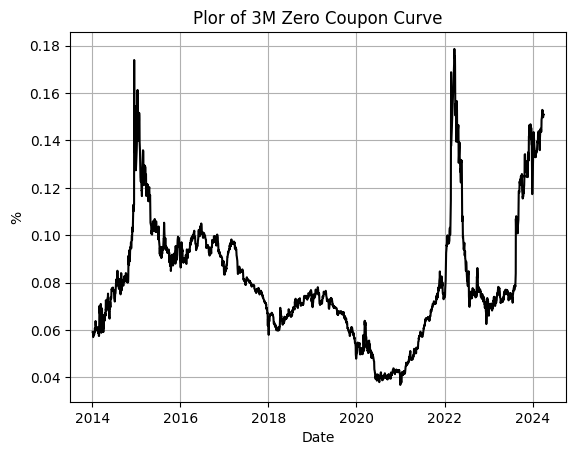

In [7]:
sr = zc[0.25]
plt.plot(sr,c = 'black')
plt.title('Plor of 3M Zero Coupon Curve')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('%')
plt.savefig('3M.png',bbox_inches='tight',dpi = 400)
plt.show()

In [8]:
dy = sr.diff(1).iloc[1:]
y = sr.iloc[:-1]

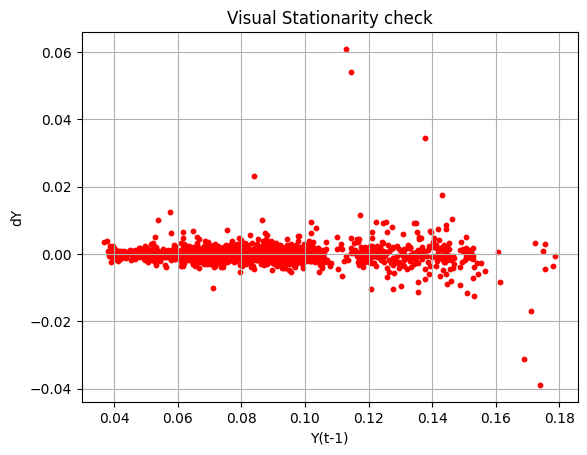

In [9]:
plt.scatter(y,dy,s = 10, color = 'red')
plt.grid(True)
plt.xlabel('Y(t-1)')
plt.ylabel('dY')
plt.title('Visual Stationarity check')
plt.show()

<h4>Estimate Vasicek model for 3M ZCB curve</h4>

In [10]:
df_3m: pd.DataFrame = zc[0.25].to_frame()
df_3m["y_t-1"] = df_3m[0.25].shift(1)

df_3m.columns = ["y_t", "y_t-1"]
df_3m["dy_t"] = df_3m["y_t"] - df_3m["y_t-1"]
df_3m = df_3m.dropna()

df_3m.head()

,y_t,y_t-1,dy_t
tradedate,,,
2014-01-08,0.059216,0.059233,-0.000017
2014-01-09,0.057783,0.059216,-0.001433
2014-01-10,0.056984,0.057783,-0.000800
2014-01-13,0.058098,0.056984,0.001115
2014-01-14,0.057827,0.058098,-0.000272


$$y_t = \beta_0 + \beta_1 y_{t-1} + \epsilon_t$$
$$\underbrace{y_t - y_{t-1}}_{\Delta y_t} = \beta_0 - \underbrace{(1 - \beta_1)}_{\gamma} y_{t-1} + \epsilon_t$$
$$\Delta y_t = \underbrace{\frac{\gamma}{\Delta t}}_{\kappa} (\underbrace{\frac{\beta_0}{\gamma}}_{\theta} - y_{t-1}) \Delta t + \epsilon_t$$

We obtain Vasicek model from the expression above as $\Delta t \rightarrow 0 $

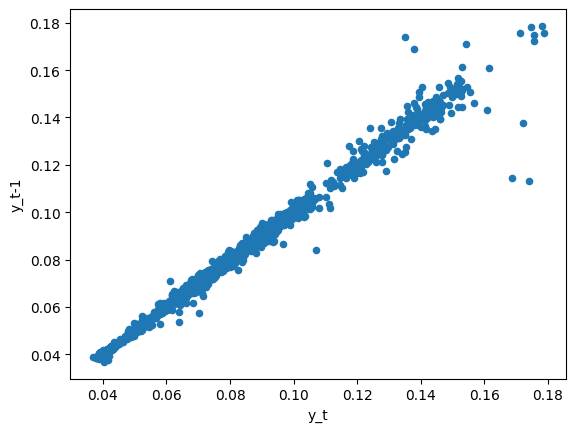

In [11]:
df_3m.plot.scatter(
    x="y_t", y="y_t-1"
)

plt.show()

<h4>OLS estimation</h4>

In [12]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant


X = df_3m["y_t-1"]
X = add_constant(X)
Y = df_3m["y_t"]

model = OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    y_t   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 2.154e+05
Date:                Sun, 14 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:42:16   Log-Likelihood:                 11500.
No. Observations:                2567   AIC:                        -2.300e+04
Df Residuals:                    2565   BIC:                        -2.298e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.217      0.0

$\hat{\kappa}_{OLS} = \frac{1 - \hat{\beta_1}}{\Delta t}$ </br>

$\hat{\theta}_{OLS} = \frac{\hat{\beta_0}}{1 - \hat{\beta_1}}$

In [13]:
dt = 1/365
beta_0, beta_1 = model.params

kappa = (1 - beta_1) / dt
theta = beta_0 / (1 - beta_1)
sigma = model.resid.std()

kappa, theta, sigma

(1.656713197979034, 0.08846612939398124, 0.0027432585818806298)

<h4>Maximum Likelihood estimation</h4>

$$dr_t = \kappa(\theta - r_{t-1})dt + \sigma dW_t$$

In [14]:
from scipy.optimize import minimize


def vasicek_likelihood(X: np.array, Y: np.array) -> float:
    dt = 1/365
    kappa, theta, sigma = X
    n_obs = len(Y)

    log_likelihood = 0

    for t in range(1, n_obs):

        drift = kappa*(theta - Y[t-1])*dt # deterministic change modelled by Vasicek
        unexplained_change = Y[t] - (Y[t-1] + drift) # change not captured deterministically by Vasicek

        pdf = (
            1 / (np.sqrt(2 * np.pi * sigma**2)) *
            np.exp(-unexplained_change**2 / (2 * sigma**2))
        ) # these unexplained changes are independant from each other, therefore tune parameters such that
        # product likelihood is highest

        log_likelihood += np.log(pdf)

    return -log_likelihood

In [15]:
res = minimize(
    fun=vasicek_likelihood,
    x0=[0.1, 0.1, 0.1],
    args=(df_3m["y_t"].values),
    method="SLSQP",
)

res.x

array([ 1.65699196,  0.08847865, -0.00274327])

In [16]:
# Further we will use MLE estimates
kappa, theta, sigma = res.x

<h4>Simulate paths for 3M ZCB curve</h4>

Vasicek closed form solution

$$dr_t = \kappa (\theta - r_t)dt + \sigma dW_t$$

$$r_T = r_0 e^{-\kappa T} + \theta (1-e^{-\kappa T}) + \sigma \int_{0}^{T}{e^{-\kappa (T-t)}}dW_t$$

In [17]:
from datetime import timedelta

In [18]:
dt = 1/365 # time delta 
n_paths: int = 50 # generate n_paths 
N: int = 365*3 # simulate n_days

W = np.random.normal(0, np.sqrt(dt), size=(n_paths, N))

R = np.ones(shape=(n_paths, N))
R[:, 0] = df_3m["y_t"].iloc[-1]

# Generate Vasicek paths
for i in range(n_paths):
    for j in range(1, N):
        # dr_t = kappa * (theta - r_t-1)dt + sigma dW
        R[i, j] = R[i, j-1] + kappa * (theta - R[i, j-1]) * dt + W[i, j] * sigma

In [19]:
df_3m_sim = pd.DataFrame(data=R.T, columns=[f"path_{i}" for i in range(1, n_paths + 1)])

start_sim_date = df_3m.index[-1] + timedelta(days=1)
end_sim_date = start_sim_date + timedelta(days=N)

df_3m_sim["date"] = pd.date_range(
    start=start_sim_date, end=end_sim_date, freq="D", inclusive="left"
)

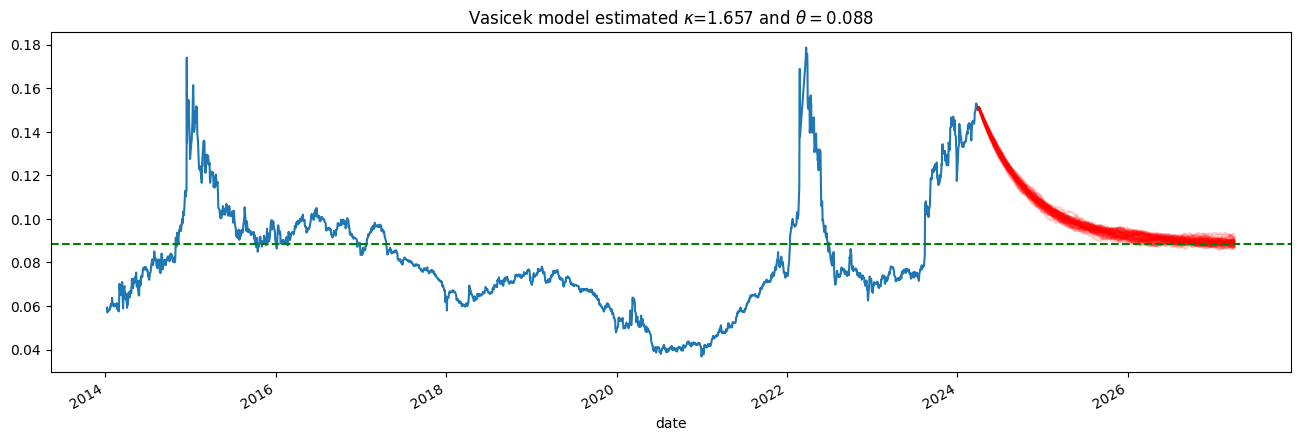

In [20]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(111)

df_3m["y_t"].plot(ax=ax)
df_3m_sim.plot(x="date", y=df_3m_sim.columns[:-1], ax=ax, legend=False, color="red", alpha=0.2)
plt.axhline(y=theta, color="green", linestyle="--")

plt.title(f"Vasicek model estimated $\\kappa$={round(kappa, 3)} and $\\theta=${round(theta, 3)}")
plt.show()

<h4>Hull White model</h4>

<p>Relax the assumption of constant theta</p>

$$dr_t = (\theta(t) -\kappa  r_t) dt + \sigma dW_t $$
$$\theta(t) = \frac{\partial f^M(0,t)}{\partial T} + \kappa f^M(0,t) + \frac{\sigma^2}{2\kappa}(1 - e^{-2\kappa t})$$

In [21]:
params =  prms_curve.iloc[-1]
fbond = lambda t: 1/(1 + gcurve(t,params))**t

def derivatives(f,a,h=0.01):
    up = f(a + h)
    down = f(a - h)
    cur = f(a)
    
    frstdrv = (up - down)/(2*h)
    scnddrv = (up + down - 2*cur)/(h**2)
    return - frstdrv, - scnddrv

In [22]:
dt = 1/365 # time delta 
n_paths: int = 50 # generate n_paths 
N: int = 365*3 # simulate n_days

W = np.random.normal(0, np.sqrt(dt), size=(n_paths, N))

RW = np.ones(shape=(n_paths, N))
RW[:, 0] = df_3m["y_t"].iloc[-1]

# Generate Hull White paths
for i in tqdm(range(n_paths)):
    for j in range(1, N):
        # dr_t = kappa * (theta - r_t-1)dt + sigma  dW
        f,s = derivatives(fbond,(j-1)/365, h=0.01)
        theta_t = s + kappa*f + sigma**2 / (2*kappa) * (1 - np.exp(-2*kappa*j/365))
        RW[i, j] = RW[i, j-1] +   (theta_t -  kappa * RW[i, j-1]) * dt + W[i, j] * sigma

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:06<00:00,  8.30it/s]


In [23]:
df_3m_HW = pd.DataFrame(
    data=RW.T, columns=[f"path_{i}" for i in range(1, n_paths + 1)]
)

start_sim_date = df_3m.index[-1] + timedelta(days=1)
end_sim_date = start_sim_date + timedelta(days=N)

df_3m_HW["date"] = pd.date_range(
    start=start_sim_date, end=end_sim_date, freq="D", inclusive="left"
)

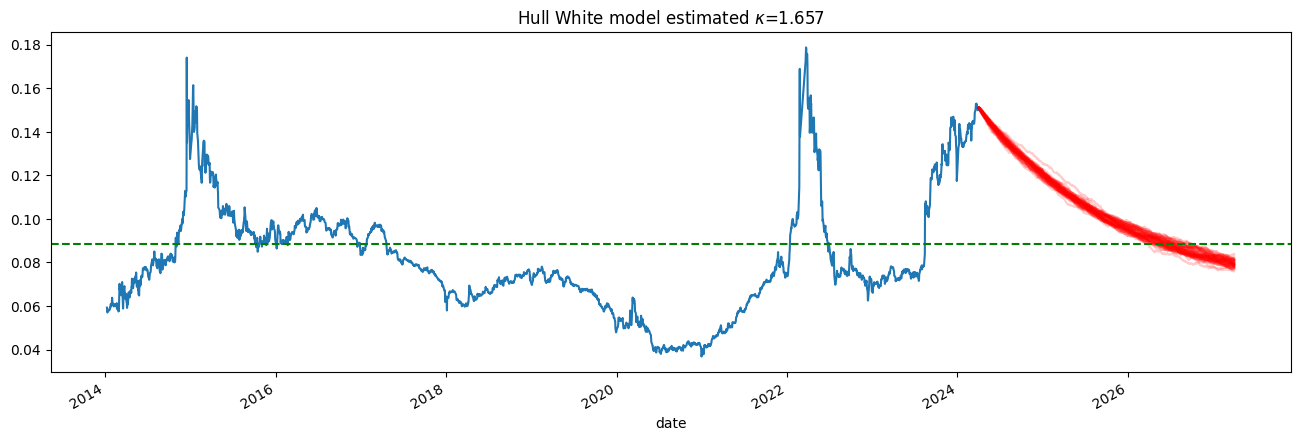

In [24]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(111)

df_3m["y_t"].plot(ax=ax)
df_3m_HW.plot(x="date", y=df_3m_HW.columns[:-1], ax=ax, legend=False, color="red", alpha=0.2)
plt.axhline(y=theta, color="green", linestyle="--")

plt.title(f"Hull White model estimated $\\kappa$={round(kappa, 3)}")
plt.show()

<h4>Plot Vasicek and Hull-White on the same plot</h4>

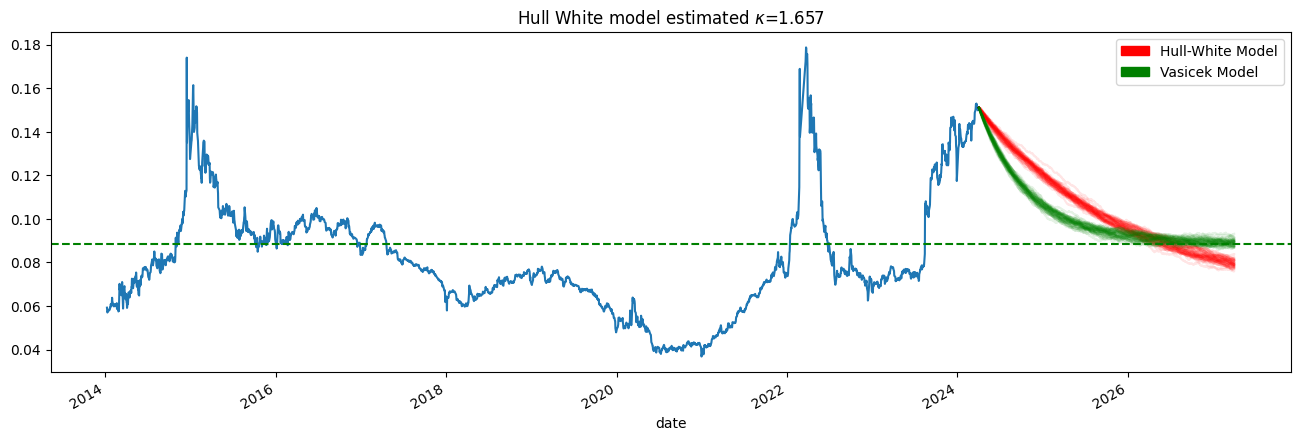

In [25]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(111)

df_3m["y_t"].plot(ax=ax)
# Plot Hull-White
df_3m_HW.plot(
    x="date", y=df_3m_HW.columns[:-1], ax=ax, legend=False, color="red", alpha=0.1
)
# Plot Vasicek model
df_3m_sim.plot(
    x="date", y=df_3m_HW.columns[:-1], ax=ax, legend=False, color="green", alpha=0.1
)

red_patch = mpatches.Patch(color="red", label="Hull-White Model")
green_patch = mpatches.Patch(color="green", label="Vasicek Model")

plt.legend(handles=[red_patch, green_patch])

plt.axhline(y=theta, color="green", linestyle="--")

plt.title(f"Hull White model estimated $\\kappa$={round(kappa, 3)}")
plt.show()

<h4>Check models' performance on the test sample</h4>

<p>We will learn the parameters using the sample up to 2021-01-31 and then backtest models using data up to today</p>

In [26]:
# train test split
df_3m["date"] = df_3m.index

df_3m_train = df_3m.iloc[df_3m.index <= "2021-01-01"].copy()
df_3m_test = df_3m.iloc[df_3m.index > "2021-01-01"].copy()

In [27]:
# learn parameters on the train set for Vasicek model
res = minimize(
    fun=vasicek_likelihood,
    x0=[0.1, 0.05, 0.1],
    bounds=[(-1000, 1000), (-0.15, 0.15), (1e-10, np.inf)],
    args=(df_3m_train["y_t"].values),
    method="SLSQP",
)

res.x

array([1.98611375, 0.07551437, 0.00239098])

In [28]:
kappa_train, theta_train, sigma_train = res.x

In [29]:
def gen_vasicek(
    theta: float, kappa: float, sigma: float, 
    r0: float, n_paths: int = 50, N: int = 365*3,
) -> np.array:
    """Generates paths for Vasicek model"""

    dt = 1 / 365  # time delta
    W = np.random.normal(0, np.sqrt(dt), size=(n_paths, N))

    R = np.ones(shape=(n_paths, N))
    R[:, 0] = r0

    # Generate Vasicek paths
    for i in tqdm(range(n_paths)):
        for j in range(1, N):
            # dr_t = kappa * (theta - r_t-1)dt + sigma dW
            R[i, j] = R[i, j - 1] + kappa * (theta - R[i, j - 1]) * dt + W[i, j] * sigma

    return R


r0 = df_3m_train["y_t"].iloc[-1]
n_days_test = df_3m_test["y_t"].shape[0]

R_test: np.array = gen_vasicek(
    theta=theta_train, kappa=kappa_train, sigma=sigma_train, r0=r0, 
    n_paths=1000,
    N=n_days_test
)

100%|██████████| 1000/1000 [00:00<00:00, 3325.52it/s]


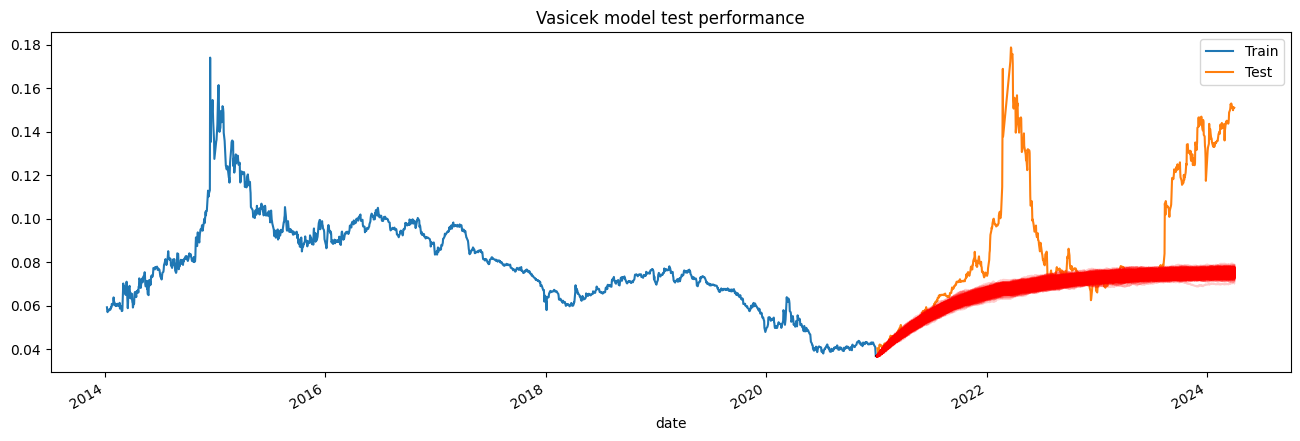

In [30]:
path_cols: List[str] = [f"path_{i}" for i in range(1, 1000 + 1)]

df_vasicek_test = pd.DataFrame(
    data=R_test.T, columns=[f"path_{i}" for i in range(1, 1000+1)]
)
df_vasicek_test["date"] = df_3m_test.index

fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(111)

df_3m_train.plot(y="y_t", ax=ax, label="Train")
df_3m_test.plot(y="y_t", ax=ax, label="Test")

df_vasicek_test.plot(
    x="date", y=df_vasicek_test.columns[:-1], ax=ax, 
    legend=False, color="red", alpha=.2
)

plt.title("Vasicek model test performance")
plt.show()

<h4>Error distribution</h4>

In [31]:
df_vasicek_test = df_vasicek_test.merge(
    df_3m_test, on="date"
)

for col in path_cols:
    df_vasicek_test[f"error_{col}"] = df_vasicek_test["y_t"] - df_vasicek_test[col]

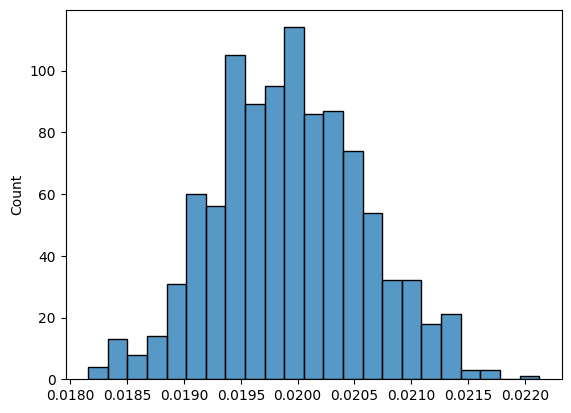

In [32]:
error_cols: List[str] = [
    col for col in df_vasicek_test.columns if "error" in col
]

sns.histplot(
    df_vasicek_test[error_cols].mean(axis=0)
)

plt.show()

In [33]:
# Hull white test

def gen_hull_white(
    kappa: float, sigma: float, 
    r0: float, n_paths: int = 50, N: int = 365*3,
) -> np.array:

    dt = 1 / 365  # time delta

    W = np.random.normal(0, np.sqrt(dt), size=(n_paths, N))

    RW = np.ones(shape=(n_paths, N))
    RW[:, 0] = r0

    # Generate Hull White paths
    for i in tqdm(range(n_paths)):
        for j in range(1, N):
            # dr_t = kappa * (theta - r_t-1)dt + sigma  dW
            f, s = derivatives(fbond, (j - 1) / 365, h=0.01)
            theta_t = (
                s + kappa * f + sigma**2 / (2 * kappa) * (1 - np.exp(-2 * kappa * j / 365))
            )
            RW[i, j] = (
                RW[i, j - 1] + (theta_t - kappa * RW[i, j - 1]) * dt + W[i, j] * sigma
            )
    
    return RW

In [34]:
R_test_hw = gen_hull_white(
    kappa=kappa_train, sigma=sigma_train, r0=r0, n_paths=1000, N=n_days_test
)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [03:04<00:00,  5.41it/s]


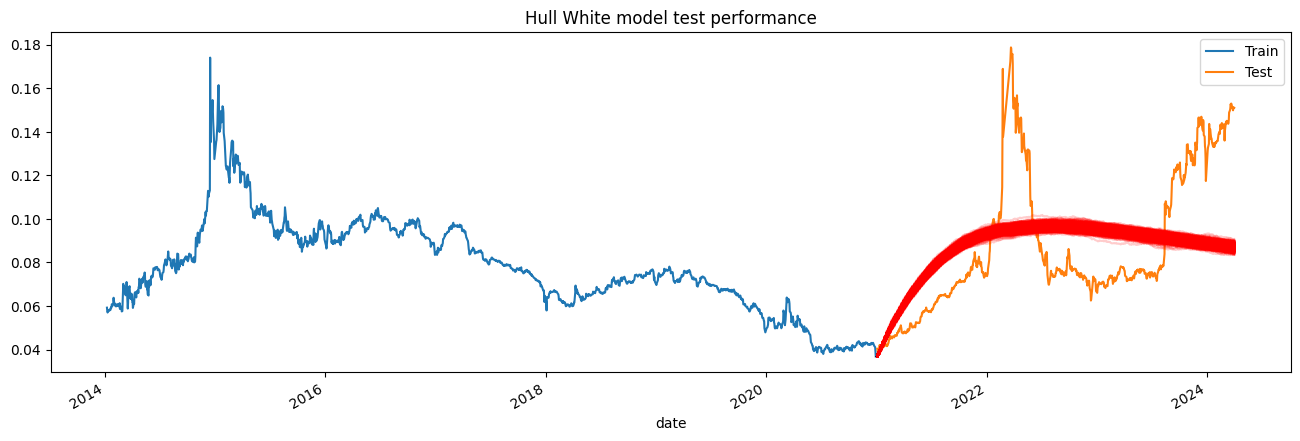

In [35]:
df_test_hw = pd.DataFrame(
    data=R_test_hw.T, columns=[f"path_{i}" for i in range(1, 1000 + 1)]
)
df_test_hw["date"] = df_3m_test.index

fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(111)

df_3m_train.plot(y="y_t", ax=ax, label="Train")
df_3m_test.plot(y="y_t", ax=ax, label="Test")

df_test_hw.plot(
    x="date", y=df_test_hw.columns[:-1],
    ax=ax, legend=False, color="red", alpha=0.2,
)

plt.title("Hull White model test performance")
plt.show()

In [36]:
df_test_hw = df_test_hw.merge(df_3m_test, on="date")

for col in path_cols:
    df_test_hw[f"error_{col}"] = df_test_hw["y_t"] - df_test_hw[col]

<h4>Comparison of the models</h4>

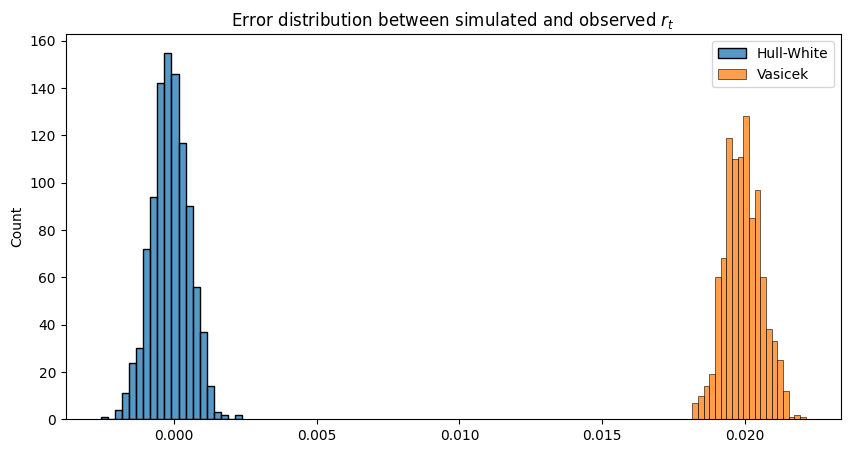

In [37]:
# Error distributions for models

error_cols: List[str] = [col for col in df_test_hw.columns if "error" in col]

plt.figure(figsize=(10, 5))

sns.histplot(df_test_hw[error_cols].mean(axis=0), bins=20, label="Hull-White")
sns.histplot(df_vasicek_test[error_cols].mean(axis=0), bins=20, label="Vasicek")

plt.title("Error distribution between simulated and observed $r_t$")
plt.legend()
plt.show()

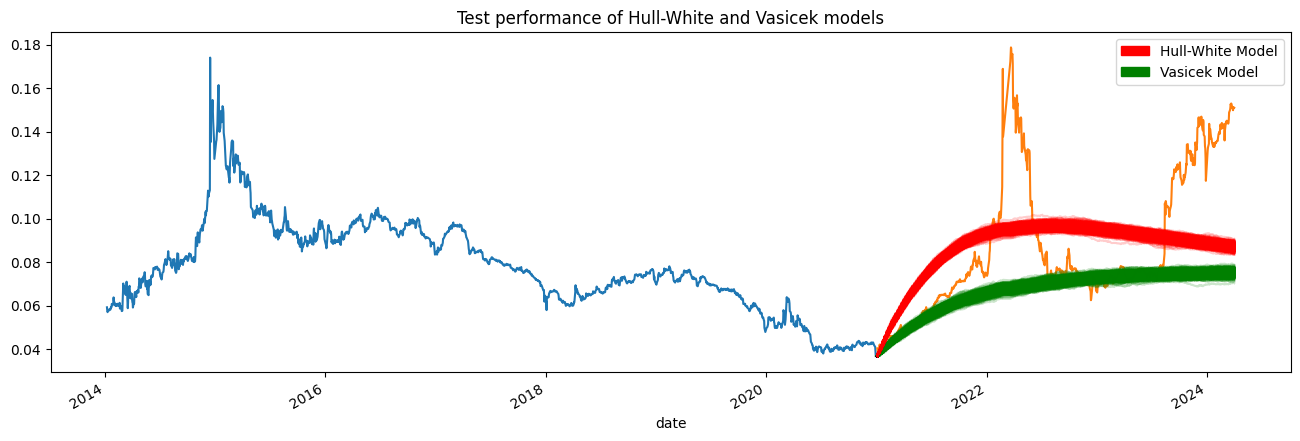

In [38]:
# plot simulated paths on the same plot

fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(111)

df_3m_train.plot(y="y_t", ax=ax, label="Train")
df_3m_test.plot(y="y_t", ax=ax, label="Test")

df_vasicek_test.plot(
    x="date", y=path_cols, ax=ax, color="green", alpha=.2, legend=False
)

df_test_hw.plot(
    x="date", y=path_cols, ax=ax, color="red", alpha=0.2, legend=False
)

red_patch = mpatches.Patch(color="red", label="Hull-White Model")
green_patch = mpatches.Patch(color="green", label="Vasicek Model")

plt.legend(handles=[red_patch, green_patch])
plt.title("Test performance of Hull-White and Vasicek models")

plt.show()

<h4>Bond pricing using different models</h4>

In [39]:
df_3m_HW['FT'] = [derivatives(fbond,j,h=0.01)[0] for j in range(1, N+1)]

t = np.arange(1,N+1)/365
B = 1/kappa - 1/kappa * np.exp(- kappa*t)

bnd_HW = pd.DataFrame()
bnd_V = pd.DataFrame()
paths = [i for i in df_3m_HW.columns if 'path' in i]
for col in paths:
    lnP_HW = df_3m_HW['FT'] *B - 1/(4*kappa**3) *sigma**2 *(np.exp(-kappa*t)-1)**2*(np.exp(2*kappa*t)-1) - df_3m_HW[col]*B
    P_HW  = np.exp(lnP_HW )
    lnP_V = (theta - sigma**2/(2*kappa**2)) * (B - t) - 1/(4*kappa) *sigma**2 *B**2 - df_3m_sim[col]*B
    P_V = np.exp(lnP_V)
    
    bnd_V[col] = P_V
    bnd_HW[col] = P_HW

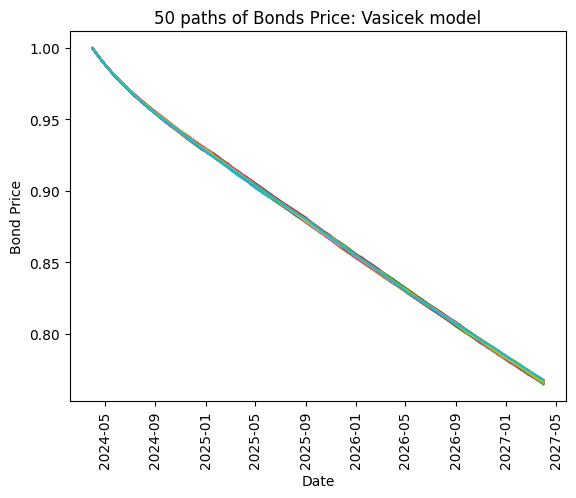

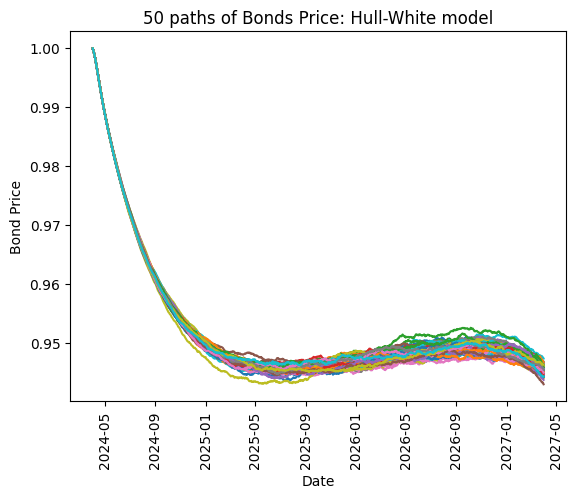

In [40]:
for col in bnd_V.columns:
    plt.plot(df_3m_HW["date"], bnd_V[col])
plt.title("50 paths of Bonds Price: Vasicek model")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Bond Price")
plt.show()


for col in bnd_V.columns:
    plt.plot(df_3m_HW["date"], bnd_HW[col])
plt.title("50 paths of Bonds Price: Hull-White model")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Bond Price")
plt.show()

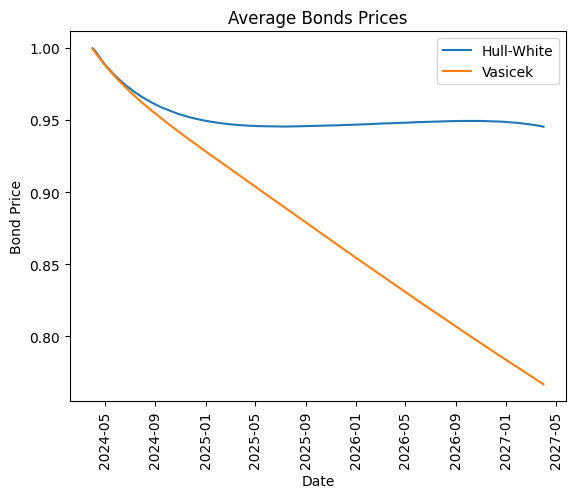

In [41]:
plt.plot(df_3m_HW["date"], bnd_HW.mean(axis=1), label="Hull-White")
plt.plot(df_3m_HW["date"], bnd_V.mean(axis=1), label="Vasicek")
plt.title("Average Bonds Prices")
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Bond Price")
plt.legend()
plt.show()